In [ ]:
#1. Download MNIST dataset

#Four files are available on this site, http://yann.lecun.com/exdb/mnist/:

    #train-images-idx3-ubyte.gz: training set images (9912422 bytes)
    #train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
    #t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
    #t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)

from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)


In [ ]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [ ]:
#Load Train and Test data into memory

!pip install seaborn==0.9.0

In [ ]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [ ]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')


In [ ]:
#Exploring the Data
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])
print(train['features'].shape[3]) #60000 examples of images of size 28 x28x 1
print(train['features'][0].shape)
print(train['features'].shape) #(60000, 28, 28, 1)
train['labels'][0]
print(train['features'][0][0][0])



# of training images: 60000
# of test images: 10000
1
(28, 28, 1)
(60000, 28, 28, 1)
[0]


In [ ]:
#Display images
def display_image(position):
   # print(train['features'][position])
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

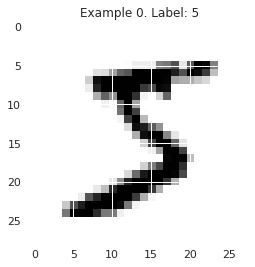

In [ ]:
display_image(0) # 0 to 59,999 examples

In [ ]:
#count of training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [ ]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [ ]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


In [ ]:
#Preparing Input data for Lenet

# Pad images with 0s

train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


In [ ]:
#Lenet model Definition

model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
EPOCHS = 10
BATCH_SIZE = 128

In [ ]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)
print(X_train.shape)


(48000, 32, 32, 1)


In [ ]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE  #375
validation_steps = X_validation.shape[0]//BATCH_SIZE #93

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

# of training images: 48000
# of validation images: 12000
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
  1/375 [..............................] - ETA: 0s - loss: 11.1770 - accuracy: 0.1641WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
375/375 [==============================] - 23s 61ms/step - loss: 0.3186 - accuracy: 0.9252 - val_loss: 0.0944 - val_accuracy: 0.9703
Epoch 2/10
375/375 [==============================] - 23s 60ms/step - loss: 0.0726 - accuracy: 0.9780 - val_loss: 0.0608 - val_accuracy: 0.9803
Epoch 3/10
375/375 [==============================] - 23s 60ms/step - loss: 0.0483 - accuracy: 0.9848 - val_loss: 0.0584 - val_accuracy: 0.9819
Epoch 4/10
375/375 [==============================] - 23s 61ms/step - l

In [ ]:
for layer in model.layers:
  g=layer.get_config()
  h=layer.get_weights()
  print (g)
  print (h)


In [ ]:
score = model.evaluate(test['features'], to_categorical(test['labels']))

print('Test loss:', score[0])
print('Test accuracy:', score[1])


313/313 [==============================] - 3s 9ms/step - loss: 0.0391 - accuracy: 0.9892
Test loss: 0.039065469056367874
Test accuracy: 0.9891999959945679


In [ ]:
model.save_weights('weights.h5')
model.save('myModel.h5')

In [ ]:
pip install hdfviewer

     |████████████████████████████████| 7.8MB 3.6MB/s 
     |████████████████████████████████| 2.0MB 47.3MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
ERROR: nbclient 0.5.0 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0


HDFViewer(children=(HDFViewer(children=(Accordion(children=(HTML(value="b'tensorflow'"), HTML(value="b'2.4.0'"…

<bound method File.close of <HDF5 file "weights.h5" (mode r)>>

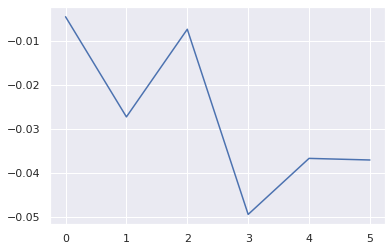

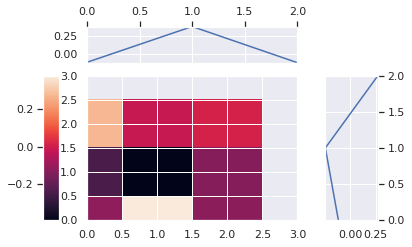

In [ ]:
%matplotlib ipympl

import h5py
from hdfviewer.widgets.HDFViewer import HDFViewer
from hdfviewer.widgets.PathSelector import PathSelector

#path = PathSelector(extensions=[".hdf",".h5",".nxs"])
#path.widget

#if path.file:
#    hdf5 = h5py.File(path.file,"r")
#    display(HDFViewer(hdf5))

hdf5 = h5py.File("weights.h5","r");
display(HDFViewer(hdf5))
hdf5.close


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

LOG_DIR = 'logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
ngrok_url = !curl -s http://localhost:4040/api/tunnels | python -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
from IPython.display import IFrame

IFrame(ngrok_url, width=700, height=900)

In [ ]:
import h5py
f = h5py.File('weights.h5', 'r')
Keylist = list(f.keys())
Keylist[0]
#dset = f['conv2d_2']


'average_pooling2d_2'

In [ ]:
dset = f['conv2d_2']
list(dset)
dset['conv2d_2']
list(dset['conv2d_2']) #['bias:0', 'kernel:0']
ddset=dset['conv2d_2']['bias:0']
ddset.value
print(ddset)

dKset = dset['conv2d_2']['kernel:0']
print(dKset)
#dKset[1][1][0][1]#-0.3789053

#dKset.shape #(3, 3, 1, 6)
#print('layer 0:')
#print(dKset[:, :, :, 0])
#print('layer 1:')
#print(dKset[:, :, :, 1])
#print('layer 2:')
#print(dKset[:, :, :, 2])
#print('layer 3:')
#print(dKset[:, :, :, 3])
#print('layer 4:')
#print(dKset[:, :, :, 4])
#print('layer 5:')
#print(dKset[:, :, :, 5])
#numpy.savetxt("foo.csv", dKset, delimiter=",")

#x = dKset[:, :, :, 0]
#with open('test.txt', 'w') as outfile:
#      for slice_2d in x:
#          np.savetxt(outfile, slice_2d)



#np.save("trial",dKset[:, :, :, 0])

<HDF5 dataset "bias:0": shape (6,), type "<f4">
<HDF5 dataset "kernel:0": shape (3, 3, 1, 6), type "<f4">


In [ ]:
#f= open("Check.txt","w+")
import numpy
a = dKset[:,: , 0, 0]
b = dKset[:,: , 0, 1]
c = dKset[:,: , 0, 2]
d = dKset[:,: , 0, 3]
e = dKset[:,: , 0, 4]
f = dKset[:,: , 0, 5]
print(a)
for slice_2d in a:
  ff = slice_2d;

s = dKset[:,:,:,:]
p = ddset[:]
ab ='\n'
print(p.flatten())
numpy.savetxt('Check.txt', (p.flatten(),s.flatten()), fmt="%s")


[[-0.11411038  0.37913567 -0.11958105]
 [-0.24184874 -0.39225495 -0.1303854 ]
 [ 0.27437076 -0.01557451  0.0141564 ]]
[-0.00453157 -0.02729397 -0.00737569 -0.04946278 -0.03672664 -0.03709113]


In [ ]:
import h5py
filename = "weights.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])
    print(data)

Keys: <KeysViewHDF5 ['average_pooling2d_2', 'average_pooling2d_3', 'conv2d_2', 'conv2d_3', 'dense_3', 'dense_4', 'dense_5', 'flatten_1']>
[]
